In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/07_PJT_final_01/01_clothes_classification

/content/drive/.shortcut-targets-by-id/1GjyX6hhmkv3p8CkgvOoSe14VWUuNEGQI/07_PJT_final_01/01_clothes_classification


In [4]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
img_size = 224
channel=3

In [6]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        # rotation_range=40,      # 40도까지 회전
        # width_shift_range=0.2,  # 20%까지 좌우 이동
        # height_shift_range=0.2, # 20%까지 상하 이동
        # shear_range=0.2,        # 20%까지 기울임
        # zoom_range=0.2,         # 20%까지 확대
        # horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/Train',
    batch_size=100,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/Validation',
    batch_size=80,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/data/test',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 32426 images belonging to 4 classes.
Found 7894 images belonging to 4 classes.
Found 10 images belonging to 4 classes.


In [7]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
valid_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
test_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}


## 모델 학습하기_VGG16
- 가중치 imagenet 사용
- 입력 데이터 사이즈 (224,224,3)
- 옵티마이저 adam, 학습률 0.0001
- train 데이터 배치사이즈 100
- 콜백함수 EarlyStopping, ModelCheckpoint
- 출력층
   * Dense(4, activation='softmax')

In [8]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 96

In [9]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet',
                                    include_top=False, 
                                    input_shape=(224, 224, 3))
vgg16.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

58900480/58889256 [==============================] - 0s 0us/step


In [10]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,926,596
Trainable params: 3,211,908
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [12]:
model_name = './model/VGG16_01_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [ ]:
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=valid_generator, 
                    callbacks = [[earlystopping, checkpointer]]) 

Epoch 1/100
325/325 [==============================] - 21459s 66s/step - loss: 0.4189 - accuracy: 0.8520 - val_loss: 0.2435 - val_accuracy: 0.9139
Epoch 2/100
 34/325 [==>...........................] - ETA: 4:16:17 - loss: 0.2800 - accuracy: 0.8953

In [13]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.8.0


In [16]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [17]:
os.listdir(checkpoint_dir)

FileNotFoundError: ignored

In [18]:
model = create_model()

# 모델을 평가합니다
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

NameError: ignored

In [16]:
history.history.keys()

NameError: ignored

In [5]:
max(history.history['accuracy'])

NameError: ignored

In [ ]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'./model/VGG16_01_model_acc{accuracy}.h5') # 최종 모델 저장

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

## 모델 저장 및 불러오기
- model.save()
  - 학습결과를 저장하기 위한 함수 모델형태(architecture)와 파라미터를 저장
  - 모델 학습 중간 과정 저장을 통해 최선의 결과 모델을 선택
  - 만들어진 모델을 다른 사람들과 공유함으로서 학습 재연성 향상

In [ ]:
model.state_dict() # 모델의 파라미터를 표시
torch.save(model.state_dict(), os.path.join(MODEL_PATH, "model.pt") # 모델 파라미터 저장

new_model = TheModelClass() # model과 같은 모델 형태의 객체

# 같은 모델의 형태에서 파라미터만 불러옴
new_model.load_state_dict(torch.load(os.path.join(MODEL_PATH, "model.pt"))

SyntaxError: ignored

In [ ]:
torch.save(model, os.path.join(MODEL_PATH, "model.pt")) # 모델의 architecture와 함께 저장
model = torch.load(os.path.join(MODEL_PATH, "model.pt")) # 모델의 architecture와 함께 불러옴

NameError: ignored

In [ ]:
checkpoint = torch.load(PATH) # checkpoint dictionary
model.load_state_dict(checkpoint['model_state_dict']) # 모델 파라미터 불러옴

# optimizer 파라미터 불러옴
optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
epoch = checkpoint['epoch'] 
loss = checkpoint['loss']

NameError: ignored

In [19]:
model.save_weights('/content/drive/MyDrive/07_PJT_final_01/01_clothes_classification/model/')

In [20]:
model = create_model()

NameError: ignored

In [21]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [17]:
# 모델 저장
# accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'/content/drive/MyDrive/07_PJT_final_01/01_clothes_classification/model/VGG16_01_11-17.2763.h5') # 최종 모델 저장

In [19]:
histpry = model.save(f'/content/drive/MyDrive/07_PJT_final_01/01_clothes_classification/model/VGG16_01_11-17.2763.h5') # 최종 모델 저장

NameError: ignored

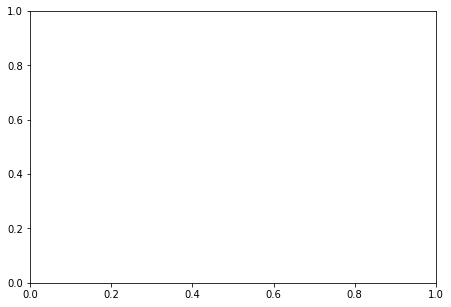

In [20]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)